## Import libraries

In [151]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/mall-customers/Mall_Customers.csv


## Import dataset

In [152]:
filepath = "/kaggle/input/mall-customers/Mall_Customers.csv"
df = pd.read_csv(filepath)
print(df.columns)
df.head()

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Transform and preprocess the data  

In [158]:
df.dropna(inplace=True)
df["Score"] = (df["Spending Score (1-100)"] // 10).astype(int)
df["Genre"] = df["Genre"].map({"Male": 1, "Female": 0})
df.head()


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),label,Score
0,1,1,19,15,39,1,3
1,2,1,21,15,81,1,8
2,3,0,20,16,6,1,0
3,4,0,23,16,77,1,7
4,5,0,31,17,40,1,4


## Normalize and prepare for modeling 

In [159]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

features = ["Genre","Age","Annual Income (k$)","Score"]
X = df[features]
X_train, X_test = train_test_split(X, random_state=42)
scaler = Normalizer().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Find the optimal number of clusters using elbow method

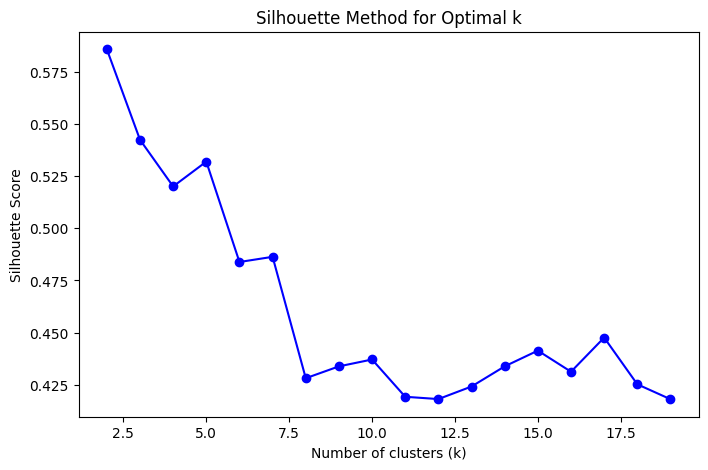

In [108]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

K = range(2, 20)
score = []

for k in K:
    model = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    labels = model.fit_predict(X_train)
    score.append(silhouette_score(X_train, labels, metric='euclidean'))

plt.figure(figsize=(8,5))
plt.plot(K, score, 'bo-', markersize=6)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

## Paramters hypertuning for KMeans

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

model = KMeans()

param_grid = {
    'n_clusters': [2,3,4,5,8],
    'init': ['k-means++', 'random'],
    'n_init': [1,3,5,10,20],
    'max_iter': [10,50,100],
    'algorithm': ['lloyd', 'elkan'],
    'tol': [1e-1,1e-2,1e-3, 1e-4,1e-5]
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring = "adjusted_mutual_info_score",
    cv=[(slice(None), slice(None))], 
    verbose=2
)

grid_search.fit(X_train)
best = grid_search.best_params_
print("Best Score:", grid_search.best_score_)

In [117]:
print(best)

{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 10, 'n_clusters': 2, 'n_init': 1, 'tol': 0.1}


## Train and fit the final model  

In [164]:
best ={'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 10, 'n_clusters': 4, 'n_init': 1, 'tol': 0.1}
model = KMeans(**best)

model.fit(X_train)
y = model.predict(X_test)
df["label"] = model.fit_predict(X)


## Evaluate the model using silhouette score

In [165]:
from sklearn.metrics import silhouette_score

print(silhouette_score(X_test,y, random_state = 42))

0.47103396988718693


## Visualize the resulting clusters in 3D

In [167]:
import plotly.express as px

fig = px.scatter_3d(
    df,
    x="Age",
    y="Annual Income (k$)",
    z="Score",
    color=df["label"].astype(str),
    hover_data=["Genre"],
    title="3D K-Means Clustering Visualization",
)

fig.update_traces(marker=dict(size=5))
fig.show()
